In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


%matplotlib inline


In [2]:
def tanh(z):
    return np.tanh(z)

def sigmoid(z):
    return 1 / (1+np.exp(-z))

def sigmoid_deriv(z):# z --> sigmoid(Z)
    return z * (1-z)

def tanh_deriv(z): # z --> tanh(Z)
    return 1 - (z)**2



def relu(Z):
    z_copy = np.array(Z,copy=True)
    return np.maximum(0,z_copy)


def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;



In [3]:
def random_weights_initialization(n_input,n_h1,n_h2,n_output):
    W1 = np.random.randn(n_input,n_h1) 
    b1 = np.zeros((1,n_h1)) 
    W2 = np.random.randn(n_h1,n_h2)  
    b2 = np.zeros((1,n_h2))
    W3 = np.random.randn(n_h2,n_output) 
    b3 = np.zeros((1,n_output))
    
    params = {
        "W1":W1,
        "W2":W2,
        "W3":W3,
        "b1":b1,
        "b2":b2,
        "b3":b3,
    }
    return params

In [4]:
def forward_prop(input_X,parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    
    layer_0  = input_X
    Z1 = np.dot(layer_0,W1) + b1
    A1 = relu(Z1)               # layer_0(input) --> Z1 --> A1 = tanh(Z1) (layer_1)
    
    Z2 = np.dot(A1,W2) + b2
    A2 = relu(Z2) # layer_1(hidden layer 1) --> Z2 --> A2 = tanh(Z1) (layer_2)
    
    Z3 = np.dot(A2,W3) + b3
    A3 = sigmoid(Z3)            # layer_2(hidden layer 2) --> Z3 --> A3 = sigmoid(Z1) (output layer)
 
    cache = {
        "A1":A1,
        "A2":A2,
        "A3":A3,
        "Z1":Z1,
        "Z2":Z2,
        "Z3":Z3,
        "b1":b1,
        "b2":b2,
        "b3":b3,
        "X":input_X,
    }
    return A3,cache

In [5]:
def compute_cost(pred_output,actual_output,parameters,lamdba):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    

    
    A = pred_output
    y =actual_output
    m = y.shape[0]
    norm=0
    for i in range(1,3):
        norm = np.linalg.norm(parameters["W"+str(i)])
        
    cost_ =  (1./m)* np.sum((A-y)**2) + (lamdba * norm)/(2*m)
    return np.squeeze(cost_)


def get_accuracy_value(Y_hat, Y):
    testing = Y_hat.copy()
    testing[Y_hat>0.5]= 1 
    testing[Y_hat <= 0.5]=0
    return (testing == Y).all(axis=1).mean()

In [6]:
def backward_prop(Y,cache,parameters):
    

    A1 = cache["A1"]
    A2 = cache["A2"]
    A3 = cache["A3"]
    X = cache["X"]
    
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    Z3 = cache["Z3"]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    b3 = parameters["b3"]
    
    
    
    AL = A3
    
    m = Y.shape[0]
    delta3  = 2*(AL - Y) * sigmoid_deriv(A3)

    
    dW3 = np.dot(A2.T,delta3)/ m 
    db3 =np.sum(delta3,axis=0,keepdims=True)/ m 
    delta2 =relu_backward(np.dot(delta3,W3.T),Z2)
    
    
    dW2 = np.dot(A1.T,delta2) / m
    db2 = np.sum(delta2,axis=0,keepdims=True)/ m
    delta1 = relu_backward(np.dot(delta2,W2.T) ,Z1)
    
    
    dW1 = np.dot(X.T,delta1) / m
    db1 = np.sum(delta1, axis=0,keepdims=True) / m

    assert (W3.shape == dW3.shape)
    assert (W2.shape == dW2.shape)
    assert (W1.shape == dW1.shape)
    assert (b3.shape == db3.shape)
    assert (b2.shape == db2.shape)
    assert (b1.shape == db1.shape)
    
    
    backward_cache = {
        "dW3":dW3,
        "db3":db3,
        "dW2":dW2,
        "db2":db2,
        "dW1":dW1,
        "db1":db1,

    }
    return backward_cache

In [7]:
def update_params(params,backward_cache,learning_rate,lamdba,m):
    W1 = params["W1"]
    W2 = params["W2"]
    W3 = params["W3"]
    b1 = params["b1"]
    b2 = params["b2"]
    b3 = params["b3"]
    
    dW3 = backward_cache["dW3"]
    db3 = backward_cache["db3"]
    dW2 = backward_cache["dW2"]
    db2 = backward_cache["db2"]
    dW1 = backward_cache["dW1"]
    db1 = backward_cache["db1"]
    
    ferb = (learning_rate * lamdba)/m

    W1 = (1-ferb)*W1 - (learning_rate *  dW1)
    W2 = (1-ferb)*W2 - (learning_rate *  dW2)
    W3 = (1-ferb)*W3 - (learning_rate *  dW3)
    b1 = b1 - (learning_rate *  db1)
    b2 = b2 - (learning_rate *  db2)
    b3 = b3 - (learning_rate *  db3)

    params = {
    "W1":W1,
    "W2":W2,
    "W3":W3,
    "b1":b1,
    "b2":b2,
    "b3":b3,
    }
    return params


In [8]:
def train(X,Y,n_hidden_neuron_1,n_hidden_neuron_2,n_iters=2000,alpha = 0.01,lambda_=10):
    n_input = X.shape[1] # input layer --> no. of features
    n_h1 = n_hidden_neuron_1 # hidden layer 1 --> no. of hidden layer 1 neurons
    n_h2 = n_hidden_neuron_2 # hidden layer 2 --> no. of hidden layer 2 neurons
    n_output = Y.shape[1] # output layer --> no. of outputs
    m = X.shape[0] # no. of samples
    
    params  = random_weights_initialization(n_input,n_h1,n_h2,n_output)
    J_cost =[]
    for i in range(n_iters):
        
        A3,cache = forward_prop(X,params)
        J = compute_cost(A3,Y,params,lambda_)
        J_cost.append(J)
        if (i%50 == 0):
            print("iter:",str(i),"cost:",str(J),"Accuracy:",str(get_accuracy_value(A3,Y)))
            print("----------------------------------------------------------------------")
          
        back_cache = backward_prop(Y,cache,params)

        params  = update_params(params,back_cache,alpha,lambda_,X.shape[0])
        

    return params,J_cost

In [9]:
def predict(input_X, parameters,threshold):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    
    layer_0  = input_X
    Z1 = np.dot(layer_0,W1) + b1
    A1 = relu(Z1)               # layer_0(input) --> Z1 --> A1 = tanh(Z1) (layer_1)
    
    Z2 = np.dot(A1,W2) + b2
    A2 = relu(Z2)               # layer_1(hidden layer 1) --> Z2 --> A2 = tanh(Z1) (layer_2)
    
    Z3 = np.dot(A2,W3) + b3
    A3 = sigmoid(Z3)     # layer_2(hidden layer 2) --> Z3 --> A3 = sigmoid(Z1) (output layer)
    
    output = np.array(A3,copy=True)
    output[output > threshold] = 1
    output[output <= threshold] = 0    

    return output
    

In [10]:
import sys, numpy as np 
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Using TensorFlow backend.
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Getting the Data for 1 and 0 to classify:

In [11]:
y_1_train = np.where(y_train == 1)
y_0_train = np.where(y_train == 0)
index_train =np.append(y_1_train[0],y_0_train[0])
np.random.shuffle(index_train)

y_1_test = np.where(y_test == 1)
y_0_test = np.where(y_test == 0)
index_test =np.append(y_1_test[0],y_0_test[0])
np.random.shuffle(index_test)


# index
x_train= x_train[(index_train)]
y_train= y_train[(index_train)]
x_test= x_test[(index_test)]
y_test= y_test[(index_test)]

print(index_train)


[16392 32843 42634 ... 50447 29514 11715]


1

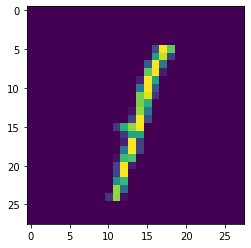

In [12]:
n_samples_train = 12000
i = np.random.randint(0, n_samples_train)
img = Image.fromarray(x_train[i])
plt.imshow(img)

y_train[i]

In [13]:
images, labels = (x_train[0:n_samples_train].reshape(n_samples_train,28*28) /255, y_train[0:n_samples_train].reshape(n_samples_train,1)) 
df = pd.DataFrame(images)


In [14]:
params_ , cost_ = train(images,labels,6,4,n_iters=3001,alpha =  0.01,lambda_=10,)


iter: 0 cost: 0.4148241472117635 Accuracy: 0.5583333333333333
----------------------------------------------------------------------
iter: 50 cost: 0.3993329103970855 Accuracy: 0.5865833333333333
----------------------------------------------------------------------
iter: 100 cost: 0.38832305764251396 Accuracy: 0.5936666666666667
----------------------------------------------------------------------
iter: 150 cost: 0.3741178621936977 Accuracy: 0.60475
----------------------------------------------------------------------
iter: 200 cost: 0.35792795426148605 Accuracy: 0.6208333333333333
----------------------------------------------------------------------
iter: 250 cost: 0.33633854299705107 Accuracy: 0.63825
----------------------------------------------------------------------
iter: 300 cost: 0.31183594897097805 Accuracy: 0.6634166666666667
----------------------------------------------------------------------
iter: 350 cost: 0.2856832625656264 Accuracy: 0.6889166666666666
------------

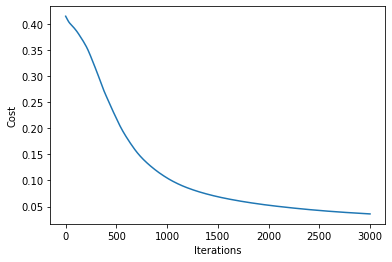

In [15]:
plt.plot(np.arange(len(cost_)),cost_)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

Testing the Trained Neural Network

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score ,f1_score
def evaluate(input_X,output_y,parameters,threshold=0.5):
    predictions = predict(input_X, parameters,threshold)
    print( " precision:" , str(precision_score(output_y,predictions))[:5],"\n",
    "recall:",str(recall_score(output_y,predictions))[:5],"\n",
    "fl score:",str(f1_score(output_y,predictions))[:5],"\n",
    "accuracy:",str((predictions == output_y).all(axis=1).mean())[:5])
    results = confusion_matrix(output_y,predictions)
    fig, ax = plt.subplots()
    ax.matshow(results)
    for (i, j), z in np.ndenumerate(results):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

In [17]:
n_test_samples = x_test.shape[0]
testX = x_test.reshape(n_test_samples,28*28)/255
testY = y_test.reshape(n_test_samples,1)

Threshold: 0.5
-------------test set-------------
 precision: 0.963 
 recall: 0.970 
 fl score: 0.966 
 accuracy: 0.964


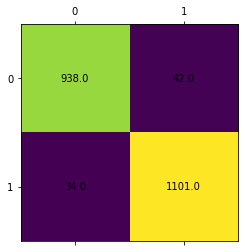

-------------train set-------------
 precision: 0.965 
 recall: 0.965 
 fl score: 0.965 
 accuracy: 0.963


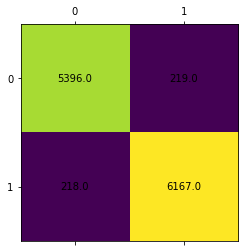

In [18]:
thres = 0.5
print("Threshold:",str(thres))
print("-------------test set-------------")
evaluate(testX,testY,params_,thres)

print("-------------train set-------------")
evaluate(images,labels,params_,thres)


Threshold: 0.8
-------------test set-------------
 precision: 0.981 
 recall: 0.930 
 fl score: 0.955 
 accuracy: 0.953


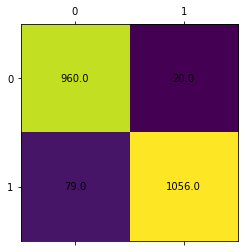

-------------train set-------------
 precision: 0.983 
 recall: 0.933 
 fl score: 0.957 
 accuracy: 0.956


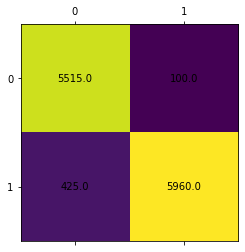

In [19]:
thres = 0.8
print("Threshold:",str(thres))
print("-------------test set-------------")
evaluate(testX,testY,params_,thres)

print("-------------train set-------------")
evaluate(images,labels,params_,thres)

Threshold: 0.3
-------------test set-------------
 precision: 0.940 
 recall: 0.985 
 fl score: 0.962 
 accuracy: 0.958


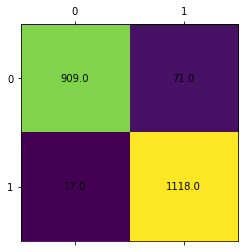

-------------train set-------------
 precision: 0.941 
 recall: 0.978 
 fl score: 0.959 
 accuracy: 0.956


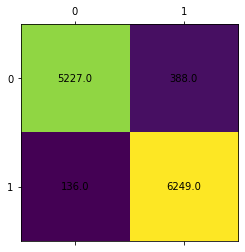

In [20]:
thres = 0.3
print("Threshold:",str(thres))
print("-------------test set-------------")
evaluate(testX,testY,params_,thres)

print("-------------train set-------------")
evaluate(images,labels,params_,thres)